## Setup

Lets setup the notebook. If the plots arent interactive then run this part again

In [24]:
from ipywidgets import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
%matplotlib notebook

And lets disable logging

In [25]:
import taurex.log
taurex.log.disableLogging()

## Loading cross-sections

We need to point TauREx3 to our cross-sections. This is handled by the caching classes. Once a cross-section is loaded it does not need to be loaded again.
First lets import the classes:

In [26]:
from taurex.cache import OpacityCache,CIACache

Now lets point the xsection and cia cachers to our files:

In [27]:
OpacityCache().set_opacity_path("C:/Users/Ahmed/Documents/TaurexData/xsec/TauRex_sampled_xsecs_R10000_0.3-15")
CIACache().set_cia_path("C:/Users/Ahmed/Documents/TaurexData/cia/hitran")

TauREx3 is now ready to use them! For fun lets, try grabbing the H2O cross-section and plotting it. First tell the OpacityCache function to grab it:

In [28]:
h2o_xsec = OpacityCache()['H2O']

Doing this the first time it slow. But repeated calls are super fast.  We can use the opacity function to 
compute the cross section for a temperature and pressure:

In [29]:
h2o_xsec.opacity(temperature=600.0,pressure=1e0)

array([4.03319460e-31, 3.42237117e-31, 3.34873403e-31, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

How about we plot it instead?

<IPython.core.display.Javascript object>


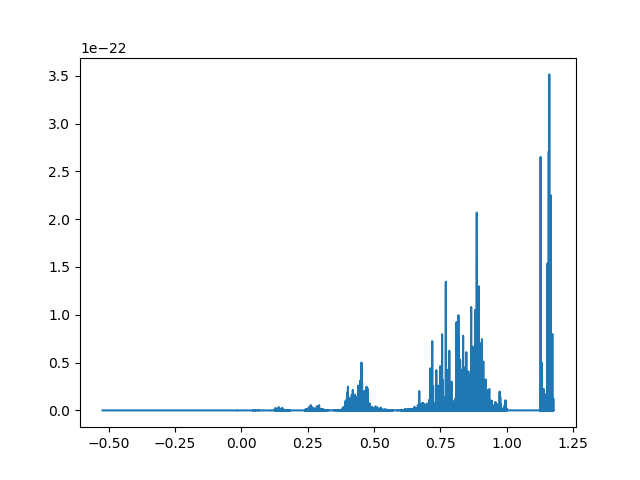

interactive(children=(FloatSlider(value=1500.0, description='temperature', max=2000.0, min=800.0), FloatSlider…

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

xsec, = ax.plot(np.log10(10000/h2o_xsec.wavenumberGrid),h2o_xsec.opacity(800,1e0))

def update_cross(temperature=1500.0,pressure=-4):

    xsec.set_ydata(h2o_xsec.opacity(temperature,10**pressure))
    ax.relim();
    ax.autoscale_view()
    fig.canvas.draw()

interact(update_cross,temperature=(800.0,2000.0),pressure=(-1.0,10.0));

Pretty cool right?

## Profiles

Now we need to setup our forward model. Lets create a temperature profile, we will use the isothermal profile but other brands are available:

In [31]:
from taurex.data.profiles.temperature import Isothermal
isothermal = Isothermal(iso_temp=1500.0)

Now lets do the same for our planet:

In [32]:
from taurex.data import Planet
planet = Planet(radius=1.1,mass=1.1)

and the planets star:

In [33]:
from taurex.data.stellar import BlackbodyStar

star = BlackbodyStar(temperature=5000.0,radius=1.0)

Now we need to define a chemistry profile, first lets setup the chemical model:

In [34]:
from taurex.data.profiles.chemistry import TaurexChemistry
chemistry = TaurexChemistry(n2_mix_ratio=0,he_h2_ratio=0.15676)

#### Adding molecules

Now we need to add some molecules. This is accomplished by the addGas function. We can create varius types of gas profiles
for each molecule and add them in. Lets try the constant profile for H2O:

In [35]:
from taurex.data.profiles.chemistry import ConstantGas

h2o = ConstantGas('H2O',mix_ratio=1e-4)
chemistry.addGas(h2o)


We can also create the gas on the spot as well:

In [36]:
chemistry.addGas(ConstantGas('CH4',mix_ratio=1e-5))

And we're done for profiles! Like the cross-sections you can use them in isolation for your own evil deeds. Some require initialization with other profiles like pressure and altitude, you can find how to use them in the API documentation. An easy example are stars. Lets create another one just for fun and plot it:

<IPython.core.display.Javascript object>


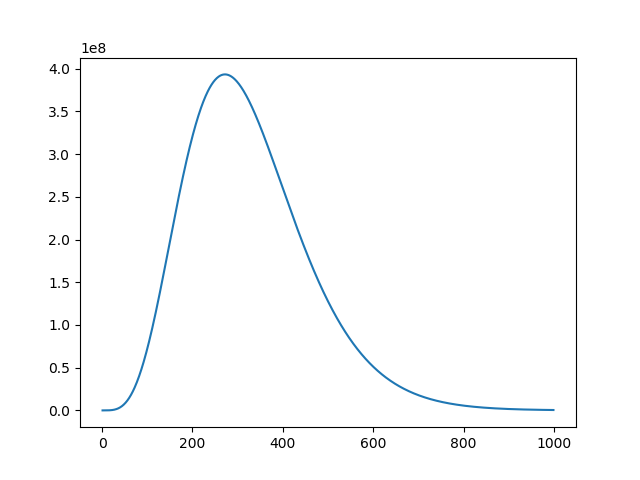

C:\Users\Ahmed\Anaconda3\envs\taurex-devel\lib\site-packages\taurex\util\emission.py:31: RuntimeWarning: divide by zero encountered in true_divide
  wl = 10000/lamb
C:\Users\Ahmed\Anaconda3\envs\taurex-devel\lib\site-packages\taurex\util\emission.py:34: RuntimeWarning: divide by zero encountered in true_divide
  BB = (pi* (2.0*h*c**2)/(wl*1e-6)**5) * (1.0/(exponent -1))
C:\Users\Ahmed\Anaconda3\envs\taurex-devel\lib\site-packages\taurex\util\emission.py:34: RuntimeWarning: invalid value encountered in multiply
  BB = (pi* (2.0*h*c**2)/(wl*1e-6)**5) * (1.0/(exponent -1))


interactive(children=(FloatSlider(value=1500.0, description='temperature', max=8000.0, min=800.0), Output()), …

In [37]:
anotherstar = BlackbodyStar(temperature=8000.0)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

wngrid = np.linspace(0,100000,1000)

anotherstar.initialize(wngrid)

pstar, = ax.plot(anotherstar.spectralEmissionDensity)

def update_cross(temperature=1500.0):
    anotherstar.temperature=temperature
    anotherstar.initialize(wngrid)
    pstar.set_ydata(anotherstar.spectralEmissionDensity)
    ax.relim();
    ax.autoscale_view()
    fig.canvas.draw()

interact(update_cross,temperature=(800.0,8000.0));


## Building the model

Now we can build our transmission model! Lets first create our transmission model and add our profiles to them:


In [38]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,temperature_profile=isothermal,chemistry=chemistry,star=star,
                        atm_min_pressure=1e-4,atm_max_pressure=1e6,nlayers=30)

At this point our atmosphere has profiles but no physics! We can add this by including some contributions. Lets add in Absorption:

In [39]:
from taurex.contributions import *
tm.add_contribution(AbsorptionContribution())

And some CIA for good measure:

In [40]:
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

Finally, putting it all together we **build** it to setup all the profiles

In [41]:
tm.build()

Thats it! Our transmission model is complete! We can now run it:

In [42]:
tm.model(return_contrib=True)

(array([0.01281005, 0.01294839, 0.01282112, ..., 0.01236506, 0.01236506,
        0.01236506]),
 array([0.01281005, 0.01294839, 0.01282112, ..., 0.01236506, 0.01236506,
        0.01236506]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.91697558e-05, 1.91697558e-05, 1.91697558e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.56986637e-02, 9.56986637e-02, 9.56986637e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.02109238e-01, 6.02109238e-01, 6.02109238e-01],
        ...,
        [9.99999833e-01, 9.99998989e-01, 9.99999982e-01, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [9.99999928e-01, 9.99999565e-01, 9.99999992e-01, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [9.99999975e-01, 9.99999849e-01, 9.99999997e-01, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]]),
 [('Absorption',
   array([0.01280989, 0.01294839, 0.01282104, ..., 0.01222

Nice! The output has four components:

- The binned flux if a grid is provided
- The *native* flux
- The optical depth
- The flux from each contribution.

Now lets plot it! lets grab the wavenumbergrid being used by model:

In [43]:
native_grid = tm.nativeWavenumberGrid

And now lets plot the flux

<IPython.core.display.Javascript object>


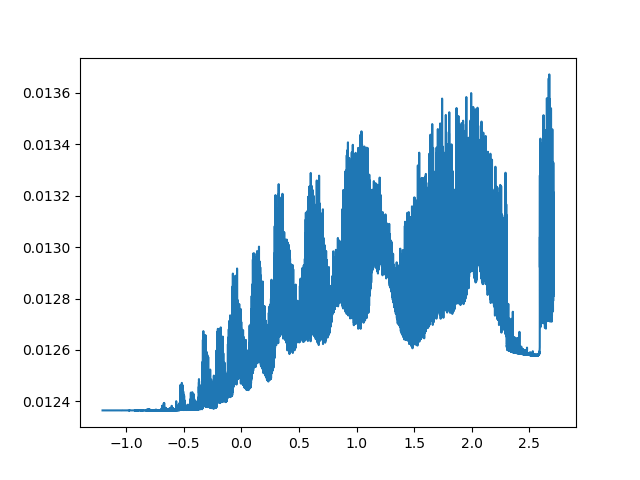

In [44]:
fig = plt.figure()
plt.plot(np.log(10000/native_grid),tm.model(return_contrib=False)[0])
plt.show()

Coool! But lets try binning

<IPython.core.display.Javascript object>


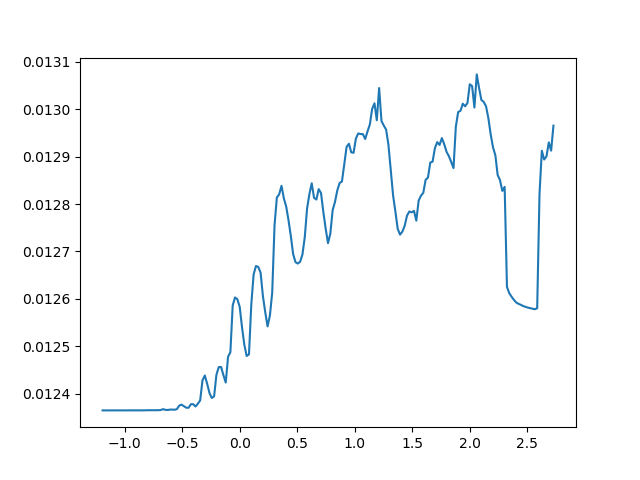

In [45]:
fig = plt.figure()

#Make a logarithmic grid
wngrid = np.sort(10000/np.power(10,np.linspace(-1,2.5,400)))

res = tm.model(wngrid=wngrid,return_contrib=False)

binned = res[0]

plt.plot(np.log(10000/wngrid),binned)
plt.show()

If any of the profiles are altered then model will respond to it. This means that parameters such as temperature and mix ratios and even contributions can be changed on the fly! Try this example out

<IPython.core.display.Javascript object>


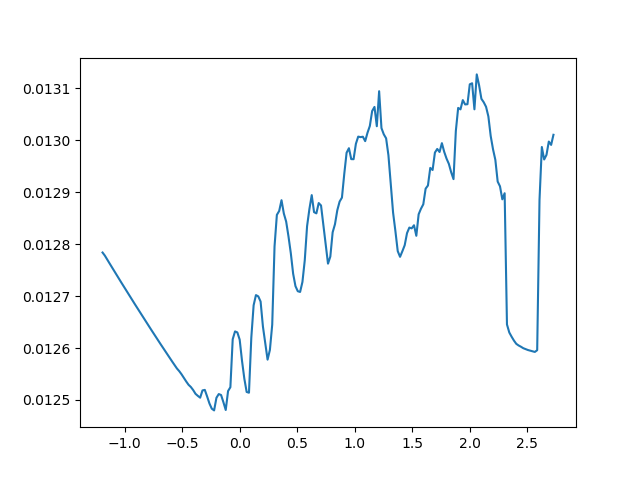

interactive(children=(Checkbox(value=False, description='Rayleigh'), Output()), _dom_classes=('widget-interact…

interactive(children=(FloatSlider(value=1500.0, description='temperature', max=2000.0, min=800.0), FloatSlider…

In [46]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

model, = ax.plot(np.log(10000/wngrid),tm.model(wngrid,return_contrib=False)[0])


@interact
def rayleighchanged(b=Checkbox(False, description='Rayleigh')):
    global tm
    tm = TransmissionModel(planet=planet,temperature_profile=isothermal,chemistry=chemistry,
                    atm_min_pressure=1e-4,atm_max_pressure=1e6,nlayers=100)

    tm.add_contribution(AbsorptionContribution())
    tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
    if b:
        tm.add_contribution(RayleighContribution())
        
    tm.build()
    model.set_ydata(tm.model(wngrid,return_contrib=False)[0])
    ax.relim();
    ax.autoscale_view()
    fig.canvas.draw()




def update_model(temperature=1500.0,h2o_mix=-4):
    isothermal.isoTemperature = temperature
    tm['H2O'] = 10**h2o_mix
    model.set_ydata(tm.model(wngrid,return_contrib=False)[0])
    ax.relim();
    ax.autoscale_view()
    fig.canvas.draw()

interact(update_model,temperature=(800.0,2000.0),h2o_mix=(-7.0,-2.0));
